In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
import os
import random
import json

In [2]:
def build_autoencoder(input_shape=(224, 224, 1)):
    # Encoder
    input_img = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    # Model
    autoencoder = Model(input_img, decoded)
    return autoencoder

In [3]:
autoencoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 1)    │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,153 (5.07 MB)

 Trainable params: 1,329,153 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Set the random seed for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


In [5]:
def load_and_preprocess_images(image_dir, num_images):
    image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.jpg')]
    random.shuffle(image_paths)
    selected_paths = image_paths[:num_images]
    
    images = []
    for path in selected_paths:
        img = load_img(path, color_mode='grayscale', target_size=(224, 224))
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img_array)
    
    images = np.array(images)
    images = images.reshape((len(images), 224, 224, 1))
    
    return images, selected_paths


In [6]:
# Load and preprocess the normal and misbehavior images
normal_image_dir = "/Users/mohitkukreja/Desktop/TEA_Lab/data_side_lane/images"  
misbehavior_image_dir = "/Users/mohitkukreja/Desktop/TEA_Lab/data/images" 

normal_images, normal_paths = load_and_preprocess_images(normal_image_dir, 750)
misbehavior_images, misbehavior_paths = load_and_preprocess_images(misbehavior_image_dir, 250)

In [7]:
# Combine the normal and misbehavior images
images = np.concatenate((normal_images, misbehavior_images), axis=0)

In [8]:
images

array([[[[0.29803923],
         [0.30588236],
         [0.30980393],
         ...,
         [0.4745098 ],
         [0.49411765],
         [0.5411765 ]],

        [[0.29803923],
         [0.30588236],
         [0.30980393],
         ...,
         [0.49411765],
         [0.5058824 ],
         [0.5254902 ]],

        [[0.29803923],
         [0.30588236],
         [0.30980393],
         ...,
         [0.5176471 ],
         [0.5176471 ],
         [0.50980395]],

        ...,

        [[0.21176471],
         [0.20784314],
         [0.21176471],
         ...,
         [0.4117647 ],
         [0.49803922],
         [0.49803922]],

        [[0.21176471],
         [0.2       ],
         [0.20392157],
         ...,
         [0.39607844],
         [0.4862745 ],
         [0.49411765]],

        [[0.19607843],
         [0.18431373],
         [0.1882353 ],
         ...,
         [0.3882353 ],
         [0.47843137],
         [0.4862745 ]]],


       [[[0.3137255 ],
         [0.3137255 ],
         [0.31

In [9]:
# Train the autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(images, images, epochs=40, batch_size=64, shuffle=True)

Epoch 1/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 116s 7s/step - loss: 0.0200
Epoch 2/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 115s 7s/step - loss: 0.0128
Epoch 3/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 246s 16s/step - loss: 0.0031
Epoch 4/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 136s 8s/step - loss: 0.0018
Epoch 5/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 135s 8s/step - loss: 0.0014
Epoch 6/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 141s 9s/step - loss: 0.0011
Epoch 7/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 138s 9s/step - loss: 9.2213e-04
Epoch 8/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 133s 8s/step - loss: 8.6457e-04
Epoch 9/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 131s 8s/step - loss: 8.3665e-04
Epoch 10/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 115s 7s/step - loss: 7.1671e-04
Epoch 11/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 117s 7s/step - loss: 7.5811e-04
Epoch 12/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 950s 63s/step - loss: 6.3440e-04
Epoch 13/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 115s 7s/step - loss: 6.0916e-04
Epoch 14/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 116s 7s/step - loss: 5.7052e-04
Epoch 15/40
16/16 ━━━━━━━━━━━━━━━━━━━

In [18]:
# Save the model using the native Keras format
autoencoder.save('autoencoder_model.keras')

In [19]:
# Save the selected image paths for consistency in future steps
selected_image_paths = {
    'normal': normal_paths,
    'misbehavior': misbehavior_paths
}

In [20]:
with open('selected_image_paths.json', 'w') as f:
    json.dump(selected_image_paths, f)

print("Training complete. Model and selected image paths saved.")

Training complete. Model and selected image paths saved.


In [21]:
image_paths = normal_paths + misbehavior_paths

In [22]:
# Calculate the reconstruction MSE
reconstructed_images = autoencoder.predict(images)
reconstruction_errors = np.mean(np.square(images - reconstructed_images), axis=(1, 2, 3))

32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 887ms/step


In [15]:
# Find the top 100 high MSE images
top_100_indices = np.argsort(reconstruction_errors)[-100:]
top_100_mse_paths = [image_paths[i] for i in top_100_indices]

In [16]:
# Check how many of the top 100 MSE images are misbehavior images
misbehavior_count = sum(1 for path in top_100_mse_paths if path in misbehavior_paths)
print(f"Number of misbehavior images in the top 100 high MSE images: {misbehavior_count}")

Number of misbehavior images in the top 100 high MSE images: 10


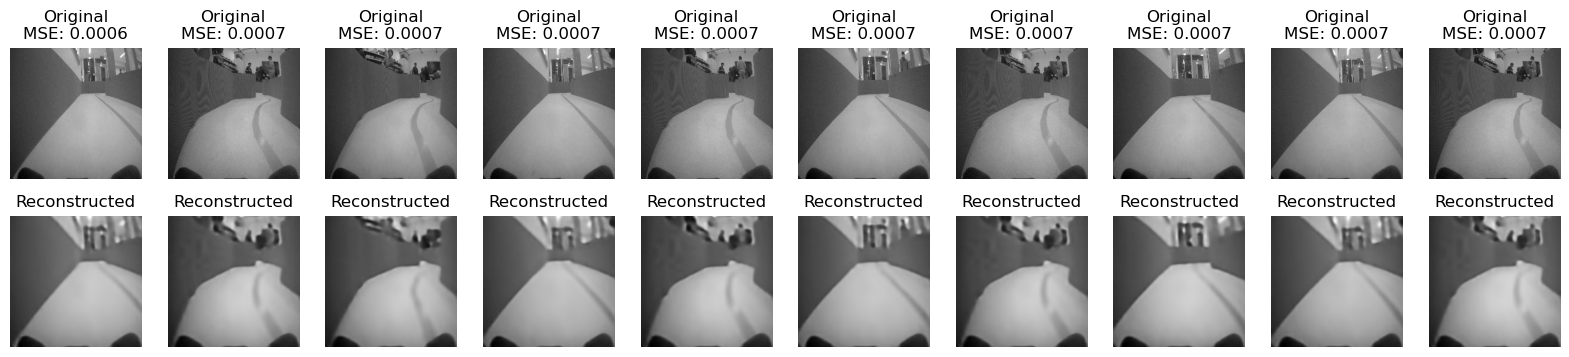

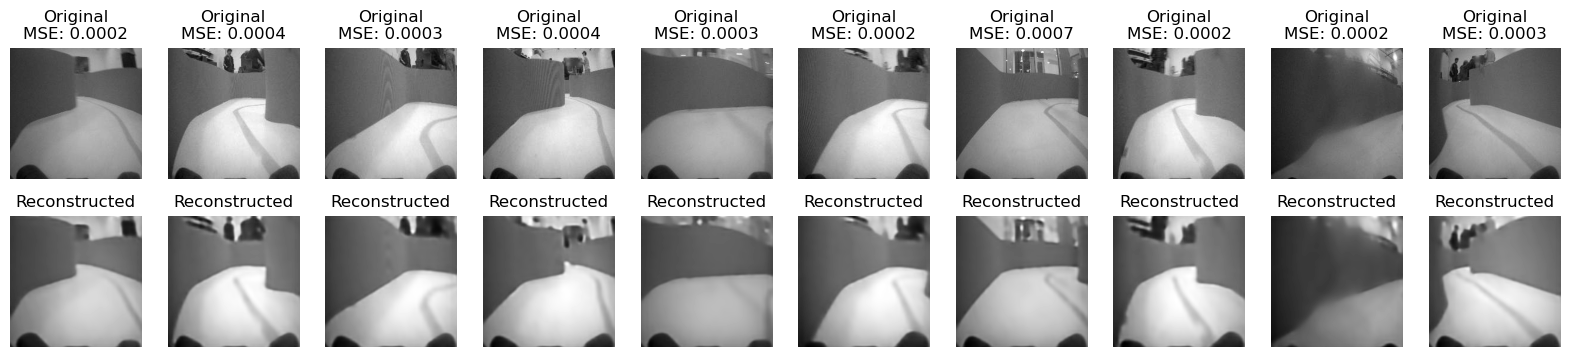

In [17]:
import matplotlib.pyplot as plt

# Function to display original and reconstructed images with MSE
def display_images(images, reconstructed_images, reconstruction_errors, indices, num_images=10):
    plt.figure(figsize=(20, 4))
    
    for i, idx in enumerate(indices[:num_images]):
        # Original image
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(images[idx].reshape(224, 224), cmap='gray')
        plt.title(f"Original\nMSE: {reconstruction_errors[idx]:.4f}")
        plt.axis("off")
        
        # Reconstructed image
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed_images[idx].reshape(224, 224), cmap='gray')
        plt.title("Reconstructed")
        plt.axis("off")
    
    plt.show()

# Display sample images from the top 100 high MSE images
display_images(images, reconstructed_images, reconstruction_errors, top_100_indices, num_images=10)

# Display sample images from random images
random_indices = np.random.choice(len(images), 10, replace=False)
display_images(images, reconstructed_images, reconstruction_errors, random_indices, num_images=10)
